In [47]:
import dill as dill
from os import listdir
from os.path import isfile, join
from fall_2021_projection_utils import aggregate_trajs_student_only

path2 = "fall_2021_prior_samples:1633456006"
with open('orig_files2_list.dill', 'rb') as fhandle:
    files2 = dill.load(fhandle)
    
with open('all_point_paths.dill', 'rb') as fhandle:
    all_point_paths = dill.load(fhandle)

In [50]:
sampled_points = {}
aggregated_trajs = {}
count = 0
while count in all_point_paths:
    path = all_point_paths[count]
    f = path
    with open(path, "rb") as fhandle:
        [point, inf_trajs_by_group] = dill.load(fhandle)
        sampled_points[f] = point
        aggregated_trajs[f] = aggregate_trajs_student_only(inf_trajs_by_group)
    count += 1
    if count % 50 == 0:
        print("Loaded {} points".format(count))
        #break
    
        
        

Loaded 50 points
Loaded 100 points
Loaded 150 points
Loaded 200 points
Loaded 250 points
Loaded 300 points
Loaded 350 points
Loaded 400 points
Loaded 450 points
Loaded 500 points
Loaded 550 points
Loaded 600 points
Loaded 650 points
Loaded 700 points
Loaded 750 points
Loaded 800 points
Loaded 850 points
Loaded 900 points
Loaded 950 points
Loaded 1000 points
Loaded 1050 points
Loaded 1100 points
Loaded 1150 points
Loaded 1200 points
Loaded 1250 points
Loaded 1300 points
Loaded 1350 points
Loaded 1400 points
Loaded 1450 points
Loaded 1500 points
Loaded 1550 points
Loaded 1600 points
Loaded 1650 points
Loaded 1700 points
Loaded 1750 points
Loaded 1800 points
Loaded 1850 points
Loaded 1900 points
Loaded 1950 points
Loaded 2000 points
Loaded 2050 points
Loaded 2100 points
Loaded 2150 points
Loaded 2200 points
Loaded 2250 points
Loaded 2300 points
Loaded 2350 points
Loaded 2400 points
Loaded 2450 points
Loaded 2500 points
Loaded 2550 points
Loaded 2600 points
Loaded 2650 points
Loaded 2700 p

In [51]:
len(sampled_points)

2977

In [52]:
import numpy as np

def convert_cum_traj_to_daily_count(traj):
    prev_cum_cases = 0
    daily_count = []
    for current_cum_cases in traj:
        daily_count.append(current_cum_cases - prev_cum_cases)
        prev_cum_cases = current_cum_cases
    return daily_count

def convert_daily_count_traj_to_weekly_count(daily_count_traj):
    weekly_count = []
    lower_idx = 0
    upper_idx = 7 
    while lower_idx <= len(daily_count_traj):
        weekly_count.append(sum(daily_count_traj[lower_idx:upper_idx]))
        lower_idx = upper_idx
        upper_idx += 7
    assert(np.abs(sum(weekly_count) - sum(daily_count_traj)) < 1e-5)
    return weekly_count

def get_weekly_counts(cum_traj):
    daily_count = convert_cum_traj_to_daily_count(cum_traj)
    return convert_daily_count_traj_to_weekly_count(daily_count)


    

In [53]:
from scipy.stats import norm
import numpy as np

ACTUAL_TRAJ = [2,2,11,23,42,57,55,39,31,48,42,25,29,4,9,8,13,14,8,8,1,7,8,5,3,6,3,0,3,4,9,3,8,1]#,0,0]

def compute_lognormal_loglik(cum_trajs):
    actual_weekly_traj = convert_daily_count_traj_to_weekly_count(ACTUAL_TRAJ)
    num_weeks = len(actual_weekly_traj)
    
    # estimate lognormal parameters
    log_counts_by_week = {week_idx:[] for week_idx in range(num_weeks)}
    for cum_traj in cum_trajs:
        weekly_counts = get_weekly_counts(cum_traj)
        for week_idx in range(num_weeks):
            log_counts_by_week[week_idx].append(np.log(weekly_counts[week_idx] + 1e-10))
            #log_counts_by_week[week_idx].append(np.log(weekly_counts[week_idx]))
    
    means_by_week = {week_idx: np.mean(log_counts_by_week[week_idx]) for week_idx in range(num_weeks)}
    stddevs_by_week = {week_idx: np.std(log_counts_by_week[week_idx]) for week_idx in range(num_weeks)}
    
    # compute log likelihood for observed data
    loglik = 0
    for week_idx, actual_positives in enumerate(actual_weekly_traj):
        log_positives = np.log(actual_positives)
        #scaled_log_positives = (log_positives - means_by_week[week_idx]) / stddevs_by_week[week_idx]
        #print(log_positives, means_by_week[week_idx], stddevs_by_week[week_idx], scaled_log_positives)
        loglik += norm.logpdf(log_positives, loc=means_by_week[week_idx], 
                                  scale=stddevs_by_week[week_idx])
    
    return loglik

#compute_lognormal_loglik(aggregated_trajs[f])

In [54]:
import numpy as np
logliks = {}
for f in sampled_points:
    logliks[f] = compute_lognormal_loglik(aggregated_trajs[f])
    #print("\n\n\n")

In [55]:
from fall_2021_projection_utils import UNCERTAINTY_PARAMS

param_vals = {}
param_logliks = {}

for idx, param in enumerate(UNCERTAINTY_PARAMS):
    param_vals[param] = []
    param_logliks[param] = []
    for f in sampled_points:
        param_vals[param].append(sampled_points[f][idx])
        param_logliks[param].append(logliks[f])
    

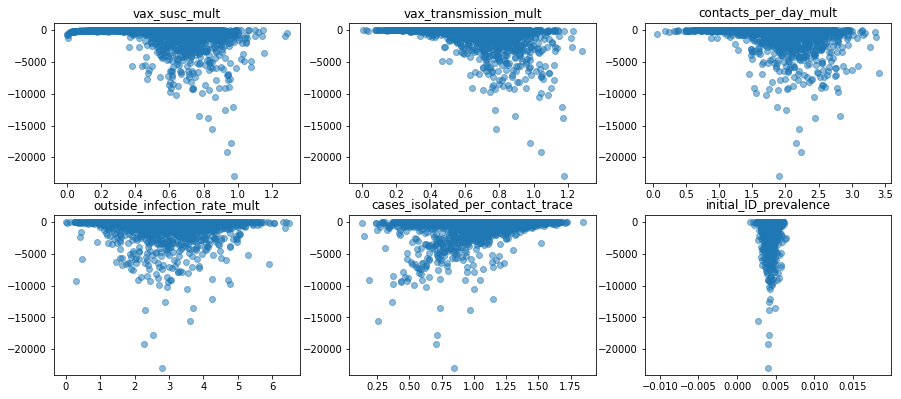

In [56]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(15,10))

for idx, param in enumerate(UNCERTAINTY_PARAMS):
    min_val = min([x for x in param_logliks[param] if x != float('-inf')])

    plt.subplot(3,3,idx+1)
    plt.scatter(param_vals[param], 
                [x if x != float('-inf') else min_val for x in param_logliks[param]],
               alpha=0.5)
    #plt.xlabel("Parameter Value")
    #plt.ylabel("Estimated Log Likelihood")
    plt.title("{}".format(param))

In [57]:
import pandas as pd
df = pd.DataFrame(param_vals)
df['log_likelihood'] = param_logliks[UNCERTAINTY_PARAMS[0]]
df['combined_spread_mult'] = df['vax_transmission_mult'] * df['vax_susc_mult'] * \
                                      df['contacts_per_day_mult']
min_loglik = min(df[df['log_likelihood'] > -np.inf]['log_likelihood'])
df.replace(-np.inf, min_loglik, inplace=True)
df.shape

(2977, 8)

In [58]:
df.shape

(2977, 8)

In [59]:
likelihoods = [np.exp(loglik) for loglik in param_logliks[UNCERTAINTY_PARAMS[0]]]
df['likelihood'] = likelihoods

In [60]:
normalizer = df['likelihood'].sum()
df['posterior'] = df['likelihood'] / normalizer

In [61]:
old_df = pd.read_csv('posterior_csvs/21_10_06_13:34_posteriors.csv')

In [62]:
old_df.head()

,Unnamed: 0,vax_susc_mult,vax_transmission_mult,contacts_per_day_mult,outside_infection_rate_mult,cases_isolated_per_contact_trace,initial_ID_prevalence,log_likelihood,combined_spread_mult,likelihood,posterior
0,0,0.536907,0.796549,1.505754,3.197843,1.194228,0.004279,-55.507721,0.643970,7.821732e-25,4.539063e-25
1,1,0.535474,0.649085,2.166687,4.640944,0.951367,0.003722,-253.572932,0.753072,7.493333e-111,4.348488e-111
2,2,0.358574,0.615210,1.625561,3.660296,0.484710,0.004324,-28.378572,0.358596,4.735247e-13,2.747932e-13
3,3,0.420128,0.760578,2.038492,4.227712,1.176410,0.002850,-82.049963,0.651380,2.323560e-36,1.348395e-36
4,4,0.646253,0.682923,1.962768,3.571786,1.156498,0.004724,-416.983907,0.866249,8.057314e-182,4.675775e-182


In [63]:
df.head()

,vax_susc_mult,vax_transmission_mult,contacts_per_day_mult,outside_infection_rate_mult,cases_isolated_per_contact_trace,initial_ID_prevalence,log_likelihood,combined_spread_mult,likelihood,posterior
0,0.536907,0.796549,1.505754,3.197843,1.194228,0.004279,-18.429392,0.643970,9.913268e-09,1.033804e-08
1,0.535474,0.649085,2.166687,4.640944,0.951367,0.003722,-108.482732,0.753072,7.701021e-48,8.031001e-48
2,0.358574,0.615210,1.625561,3.660296,0.484710,0.004324,-14.486830,0.358596,5.110341e-07,5.329313e-07
3,0.420128,0.760578,2.038492,4.227712,1.176410,0.002850,-23.362595,0.651380,7.140919e-11,7.446899e-11
4,0.646253,0.682923,1.962768,3.571786,1.156498,0.004724,-237.879319,0.866249,4.901446e-104,5.111467e-104


In [64]:
old_df.shape

(2977, 11)

In [65]:
df.columns

Index(['vax_susc_mult', 'vax_transmission_mult', 'contacts_per_day_mult',
       'outside_infection_rate_mult', 'cases_isolated_per_contact_trace',
       'initial_ID_prevalence', 'log_likelihood', 'combined_spread_mult',
       'likelihood', 'posterior'],
      dtype='object')

In [66]:
old_df.columns

Index(['Unnamed: 0', 'vax_susc_mult', 'vax_transmission_mult',
       'contacts_per_day_mult', 'outside_infection_rate_mult',
       'cases_isolated_per_contact_trace', 'initial_ID_prevalence',
       'log_likelihood', 'combined_spread_mult', 'likelihood', 'posterior'],
      dtype='object')

In [67]:
old_df.head()

,Unnamed: 0,vax_susc_mult,vax_transmission_mult,contacts_per_day_mult,outside_infection_rate_mult,cases_isolated_per_contact_trace,initial_ID_prevalence,log_likelihood,combined_spread_mult,likelihood,posterior
0,0,0.536907,0.796549,1.505754,3.197843,1.194228,0.004279,-55.507721,0.643970,7.821732e-25,4.539063e-25
1,1,0.535474,0.649085,2.166687,4.640944,0.951367,0.003722,-253.572932,0.753072,7.493333e-111,4.348488e-111
2,2,0.358574,0.615210,1.625561,3.660296,0.484710,0.004324,-28.378572,0.358596,4.735247e-13,2.747932e-13
3,3,0.420128,0.760578,2.038492,4.227712,1.176410,0.002850,-82.049963,0.651380,2.323560e-36,1.348395e-36
4,4,0.646253,0.682923,1.962768,3.571786,1.156498,0.004724,-416.983907,0.866249,8.057314e-182,4.675775e-182


In [68]:
with open('posterior_point_paths.dill', 'rb') as fhandle:
    posterior_point_paths = dill.load(fhandle)

In [69]:
old_posterior_idxs = set(posterior_point_paths.keys())

In [70]:
new_coverage = 0
old_coverage = 0
for idx in old_posterior_idxs:
    new_coverage += df['posterior'].iloc[idx]
    old_coverage += old_df['posterior'].iloc[idx]
print(old_coverage, new_coverage)

0.9508405679054797 0.007989643917259984


In [29]:
df.head()

,vax_susc_mult,vax_transmission_mult,contacts_per_day_mult,outside_infection_rate_mult,cases_isolated_per_contact_trace,initial_ID_prevalence,log_likelihood,combined_spread_mult,likelihood,posterior
0,0.342047,0.547140,2.512640,4.703389,0.732153,0.004715,-43.033369,0.470234,2.045716e-19,2.133373e-19
1,0.424383,0.732657,0.969161,1.911298,0.632296,0.004440,-17.138120,0.301339,3.605860e-08,3.760367e-08
2,0.541214,0.611493,0.951695,2.740860,1.159411,0.003784,-14.541181,0.314962,4.840000e-07,5.047388e-07
3,0.485965,0.362049,1.724864,2.757266,0.903751,0.005018,-7.087641,0.303478,8.353661e-04,8.711605e-04
4,0.560094,0.602634,2.052858,2.743192,1.186104,0.005808,-104.995508,0.692904,2.517852e-46,2.625739e-46


In [30]:
old_df.head()

,Unnamed: 0,vax_susc_mult,vax_transmission_mult,contacts_per_day_mult,outside_infection_rate_mult,cases_isolated_per_contact_trace,initial_ID_prevalence,log_likelihood,combined_spread_mult,likelihood,posterior
0,0,0.536907,0.796549,1.505754,3.197843,1.194228,0.004279,-55.507721,0.643970,7.821732e-25,4.539063e-25
1,1,0.535474,0.649085,2.166687,4.640944,0.951367,0.003722,-253.572932,0.753072,7.493333e-111,4.348488e-111
2,2,0.358574,0.615210,1.625561,3.660296,0.484710,0.004324,-28.378572,0.358596,4.735247e-13,2.747932e-13
3,3,0.420128,0.760578,2.038492,4.227712,1.176410,0.002850,-82.049963,0.651380,2.323560e-36,1.348395e-36
4,4,0.646253,0.682923,1.962768,3.571786,1.156498,0.004724,-416.983907,0.866249,8.057314e-182,4.675775e-182


In [134]:
import time
time.strftime("%y_%m_%d_%H:%M_posteriors.csv", time.localtime())


'21_10_06_13:24_posteriors.csv'

In [136]:
logliks['point_53_with_trajectories.dill']

-55.50772131684638

In [99]:
import time
csv_name = time.strftime("posterior_csvs/%y_%m_%d_%H:%M_posteriors.csv", time.localtime())
df.to_csv(csv_name)

In [100]:
csv_name

'posterior_csvs/21_10_08_14:44_posteriors.csv'

In [73]:
sorted_df = df.dropna().sort_values(by='posterior', ascending=False)

In [74]:
num_points = list(range(df.shape[0]))
posterior_mass = []

for n in num_points:
    subdf = sorted_df.head(n=n)
    posterior_mass.append(subdf['posterior'].sum())
    

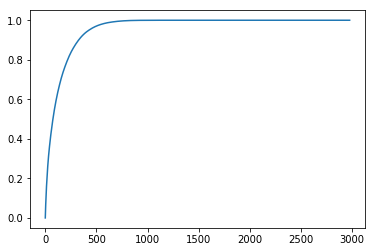

In [75]:
plt.plot(num_points, posterior_mass)

In [89]:
posterior_mass[428]

0.9503059700120384

Text(0.5,1,'number of points vs. posterior mass, using fixed likelihood values')

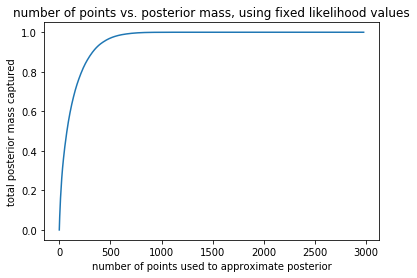

In [91]:
plt.plot(num_points, posterior_mass)
plt.xlabel("number of points used to approximate posterior")
plt.ylabel("total posterior mass captured")
plt.title("number of points vs. posterior mass, using fixed likelihood values")

Text(0.5,1,'distribution of log-normal log-likelihoods')

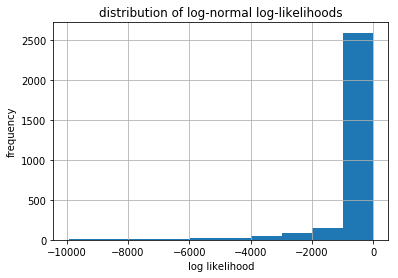

In [92]:
subdf = df[df['log_likelihood'] > -10000]
subdf['log_likelihood'].hist()
plt.xlabel('log likelihood')
plt.ylabel('frequency')
plt.title('distribution of log-normal log-likelihoods')

Text(0.5,1,'distribution of log-normal log-likelihoods')

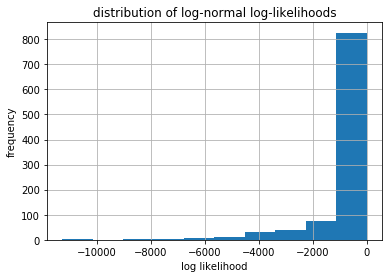

In [71]:
df['log_likelihood'].hist()
plt.xlabel('log likelihood')
plt.ylabel('frequency')
plt.title('distribution of log-normal log-likelihoods')

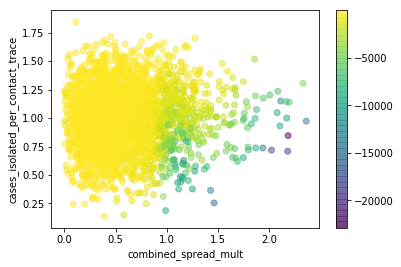

In [93]:
plt.scatter(df['combined_spread_mult'], df['cases_isolated_per_contact_trace'],
           c=df['log_likelihood'], alpha=0.5)
plt.xlabel('combined_spread_mult')
plt.ylabel('cases_isolated_per_contact_trace')
plt.colorbar()

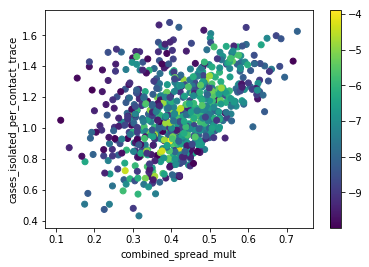

In [94]:
subdf = df[df['log_likelihood'] >= -10]
plt.scatter(subdf['combined_spread_mult'], subdf['cases_isolated_per_contact_trace'],
           c=subdf['log_likelihood'])
plt.xlabel('combined_spread_mult')
plt.ylabel('cases_isolated_per_contact_trace')
plt.colorbar()

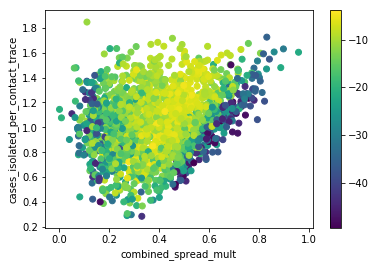

In [95]:
subdf = df[df['log_likelihood'] >= -50]
plt.scatter(subdf['combined_spread_mult'], subdf['cases_isolated_per_contact_trace'],
           c=subdf['log_likelihood'])
plt.xlabel('combined_spread_mult')
plt.ylabel('cases_isolated_per_contact_trace')
plt.colorbar()

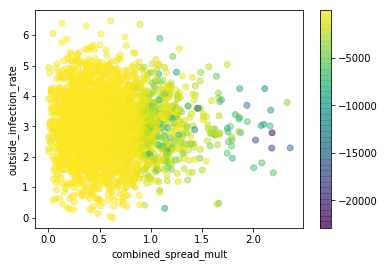

In [96]:
plt.scatter(df['combined_spread_mult'], df['outside_infection_rate_mult'],
           c=df['log_likelihood'], alpha=0.5)
plt.xlabel('combined_spread_mult')
plt.ylabel('outside_infection_rate')
plt.colorbar()
plt.show()



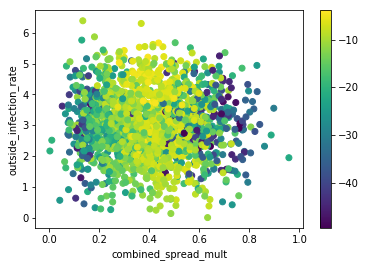

In [97]:
plt.scatter(subdf['combined_spread_mult'], subdf['outside_infection_rate_mult'],
           c=subdf['log_likelihood'])
plt.xlabel('combined_spread_mult')
plt.ylabel('outside_infection_rate')
plt.colorbar()

In [117]:
df[df['log_likelihood'].isnull()]

,vax_susc_mult,vax_transmission_mult,contacts_per_day_mult,outside_infection_rate_mult,cases_isolated_per_contact_trace,initial_ID_prevalence,log_likelihood,combined_spread_mult,likelihood,posterior


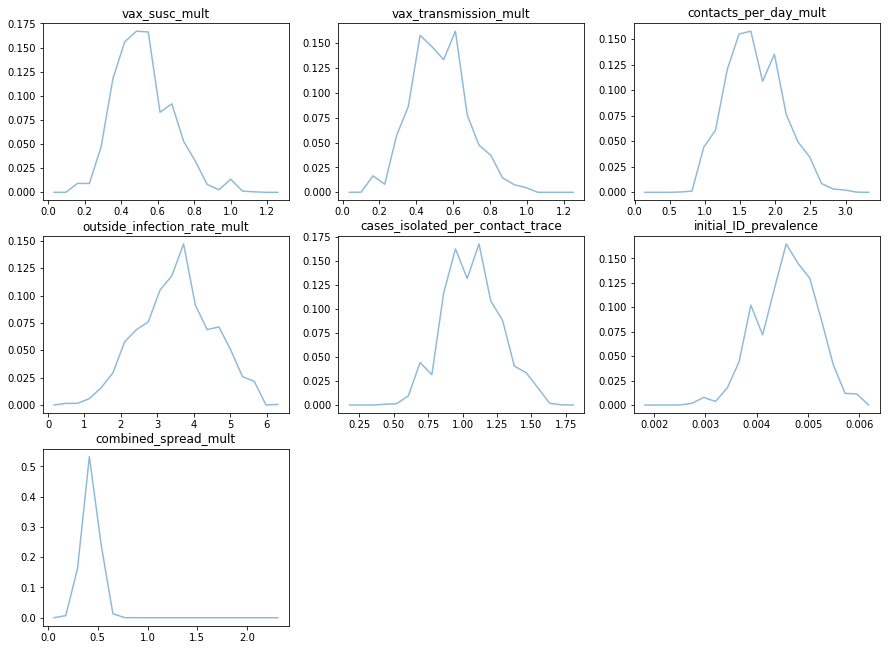

In [98]:
def estimate_marginal_dist(df, param, num_buckets=10):
    bin_boundaries = np.linspace(min(df[param]), max(df[param]), num=num_buckets+1)
    num_bins = len(bin_boundaries) - 1
    bin_centres = []
    bin_likelihoods = []
    for bin_start_idx in range((num_bins)):
        bin_start_val = bin_boundaries[bin_start_idx]
        bin_end_val = bin_boundaries[bin_start_idx + 1]
        bin_centres.append(0.5 * (bin_start_val + bin_end_val))
        
        subdf = df[(df[param] >= bin_start_val) & (df[param] < bin_end_val)]
        
        cum_likelihood = 0
        for loglik in subdf['log_likelihood']:
            if np.isnan(loglik):
                continue
            cum_likelihood += np.exp(loglik)
            if np.isnan(np.exp(loglik)):
                print(loglik)
        
        bin_likelihoods.append(cum_likelihood)
    return bin_centres, bin_likelihoods
        

plt.figure(figsize=(15,15))
num_buckets=20
for idx, param in enumerate(UNCERTAINTY_PARAMS + ['combined_spread_mult']):

    plt.subplot(4,3,idx+1)
    centres, likelihoods = estimate_marginal_dist(df, param, num_buckets=num_buckets)
    #print(param, likelihoods)
    plt.plot(centres, 
                likelihoods,
               alpha=0.5)
    #plt.xlabel("Parameter Value")
    #plt.ylabel("Estimated Log Likelihood")
    plt.title("{}".format(param))

# Code to compute symmetric 95% Credible Intervals

In [124]:
sorted_data = sorted(np.array(df[['vax_susc_mult', 'posterior']]), key=lambda x: x[0])

cum_posterior = 0
current_value = -1


In [130]:
def get_credible_interval(df, param, q=0.95):
    sorted_data = sorted(np.array(df[[param, 'posterior']]), key=lambda x: x[0])
    lower_q = (1 - q) / 2
    upper_q = q + lower_q
    cum_posterior = 0
    prev_cum_posterior = 0
    interval_lb = None
    interval_ub = None
    
    for param_val, posterior_mass in sorted_data:
        prev_cum_posterior = cum_posterior
        cum_posterior += posterior_mass
        
        if prev_cum_posterior < lower_q and cum_posterior >= lower_q:
            interval_lb = param_val
        
        if prev_cum_posterior < upper_q and cum_posterior >= upper_q:
            interval_ub = param_val
    
    return interval_lb, interval_ub

get_credible_interval(df, 'vax_transmission_mult', q=0.99)
        
    

(0.1683756285194905, 0.937907765196814)

# code for pairwise marginal distribution

[0.19111282 0.27046612 0.34981943 0.42917273 0.50852603 0.58787934
 0.66723264 0.74658594 0.82593925 0.90529255 0.98464586]
[0.16837563 0.24532884 0.32228206 0.39923527 0.47618848 0.5531417
 0.63009491 0.70704812 0.78400134 0.86095455 0.93790777]


Text(0,0.5,'vax_transmission_mult')

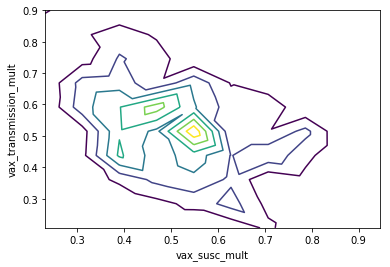

In [132]:
def estimate_pairwise_marginal_dist(df, param1, param2, num_bins=10):
    lb1, ub1 = get_credible_interval(df, param1, q=0.99)
    bin1_boundaries = np.linspace(lb1, ub1, num=num_bins+1)
    
    lb2, ub2 = get_credible_interval(df, param2, q=0.99)
    bin2_boundaries = np.linspace(lb2, ub2, num=num_bins+1)
    
    print(bin1_boundaries)
    print(bin2_boundaries)
    bin_xs = []
    bin_ys = []
    bin_likelihoods = []
    
    
    for bin1_start_idx in range((num_bins)):
        bin1_start_val = bin1_boundaries[bin1_start_idx]
        bin1_end_val = bin1_boundaries[bin1_start_idx + 1]
        bin1_centre = 0.5 * (bin1_start_val + bin1_end_val)
        
        for bin2_start_idx in range((num_bins)):
            bin2_start_val = bin2_boundaries[bin2_start_idx]
            bin2_end_val = bin2_boundaries[bin2_start_idx + 1]
            bin2_centre = 0.5 * (bin2_start_val + bin2_end_val)
        
            subdf = df[(df[param1] >= bin1_start_val) & (df[param1] < bin1_end_val) & \
                      (df[param2] >= bin2_start_val) & (df[param2] < bin2_end_val) ]
        
            cum_likelihood = 0
            for loglik in subdf['log_likelihood']:
                if np.isnan(loglik):
                    continue
                cum_likelihood += np.exp(loglik)
                if np.isnan(np.exp(loglik)):
                    print(loglik)
        
            bin_likelihoods.append(cum_likelihood)
            bin_xs.append(bin1_centre)
            bin_ys.append(bin2_centre)
    return bin_xs, bin_ys, bin_likelihoods
        

    
x, y, z = estimate_pairwise_marginal_dist(df, 'vax_susc_mult', 'vax_transmission_mult')

plt.figure()
plt.tricontour(x,y,z)
plt.xlabel("vax_susc_mult")
plt.ylabel("vax_transmission_mult")

In [104]:
xs

[0.06546642523720714,
 0.06546642523720714,
 0.06546642523720714,
 0.06546642523720714,
 0.06546642523720714,
 0.06546642523720714,
 0.06546642523720714,
 0.06546642523720714,
 0.06546642523720714,
 0.06546642523720714,
 0.19429210297715083,
 0.19429210297715083,
 0.19429210297715083,
 0.19429210297715083,
 0.19429210297715083,
 0.19429210297715083,
 0.19429210297715083,
 0.19429210297715083,
 0.19429210297715083,
 0.19429210297715083,
 0.3231177807170945,
 0.3231177807170945,
 0.3231177807170945,
 0.3231177807170945,
 0.3231177807170945,
 0.3231177807170945,
 0.3231177807170945,
 0.3231177807170945,
 0.3231177807170945,
 0.3231177807170945,
 0.4519434584570382,
 0.4519434584570382,
 0.4519434584570382,
 0.4519434584570382,
 0.4519434584570382,
 0.4519434584570382,
 0.4519434584570382,
 0.4519434584570382,
 0.4519434584570382,
 0.4519434584570382,
 0.5807691361969819,
 0.5807691361969819,
 0.5807691361969819,
 0.5807691361969819,
 0.5807691361969819,
 0.5807691361969819,
 0.58076913619

# Two-Days-Later Investigation to find the trajectories associated with our 106 points, as well as the size of the dataset against which our 106 points were obtained

In [139]:
df.shape

(2977, 10)

# size of the dataset = 2977. that wasn't so bad

In [140]:
df.head()

,vax_susc_mult,vax_transmission_mult,contacts_per_day_mult,outside_infection_rate_mult,cases_isolated_per_contact_trace,initial_ID_prevalence,log_likelihood,combined_spread_mult,likelihood,posterior
0,0.536907,0.796549,1.505754,3.197843,1.194228,0.004279,-55.507721,0.643970,7.821732e-25,4.539063e-25
1,0.535474,0.649085,2.166687,4.640944,0.951367,0.003722,-253.572932,0.753072,7.493333e-111,4.348488e-111
2,0.358574,0.615210,1.625561,3.660296,0.484710,0.004324,-28.378572,0.358596,4.735247e-13,2.747932e-13
3,0.420128,0.760578,2.038492,4.227712,1.176410,0.002850,-82.049963,0.651380,2.323560e-36,1.348395e-36
4,0.646253,0.682923,1.962768,3.571786,1.156498,0.004724,-416.983907,0.866249,8.057314e-182,4.675775e-182


In [141]:
from launch_fall_2021_posterior_sims_whale import load_posterior_df
best_points_df = load_posterior_df()
best_points_df.head()

,Unnamed: 0,vax_susc_mult,vax_transmission_mult,contacts_per_day_mult,outside_infection_rate_mult,cases_isolated_per_contact_trace,initial_ID_prevalence,log_likelihood,combined_spread_mult,likelihood,posterior
2346,2346,0.494898,0.643708,1.165605,1.500197,1.175453,0.005546,-2.478925,0.371326,0.083833,0.048650
2808,2808,0.195144,0.393487,2.178645,1.919851,0.816917,0.005811,-2.485864,0.167291,0.083254,0.048313
71,71,0.584703,0.490781,1.051848,1.300272,0.949628,0.004883,-2.504396,0.301839,0.081725,0.047426
1215,1215,0.555763,0.198611,1.517553,1.828590,0.922839,0.004893,-2.560789,0.167508,0.077244,0.044826
2213,2213,0.450848,0.203761,1.457864,1.908646,0.845300,0.005572,-2.713517,0.133927,0.066303,0.038477


In [146]:
best_point_idxs = set(best_points_df['Unnamed: 0'])
len(best_point_idxs)

106

In [148]:
best_point_fs = {}

idx = 0
for f in sampled_points:
    if idx in best_point_idxs:
        best_point_fs[idx] = f
    idx += 1


In [149]:
best_point_fs[5]

'point_71_with_trajectories.dill'

In [162]:
tuple(sampled_points['point_71_with_trajectories.dill'])

(0.5568346733832142,
 0.16309150908141595,
 2.201928782396558,
 2.2223121408632713,
 1.1114158104521341,
 0.0038614730958053557)

In [161]:
tuple(best_points_df[best_points_df['Unnamed: 0'] == 5][UNCERTAINTY_PARAMS].iloc[0])

(0.5568346733832142,
 0.16309150908141595,
 2.2019287823965583,
 2.222312140863272,
 1.111415810452134,
 0.003861473095805356)

In [167]:
for idx in best_point_idxs:
    f = best_point_fs[idx]
    sampled_point = list(sampled_points[f])
    df_point = list(best_points_df[best_points_df['Unnamed: 0'] == idx][UNCERTAINTY_PARAMS].iloc[0])
    assert(np.linalg.norm(np.array(sampled_point) - np.array(df_point)) < 1e-5)

In [169]:
with open('posterior_points.dill', 'wb') as fhandle:
    dill.dump(best_point_fs, fhandle)

In [170]:
posterior_point_paths = {}
for idx, f in best_point_fs.items():
    posterior_point_paths[idx] = join(path2, f)

In [172]:
with open('posterior_point_paths.dill', 'wb') as fhandle:
    dill.dump(posterior_point_paths, fhandle)

In [165]:
sampled_points[best_point_fs[1027]]

[0.45287212186915055,
 0.3461045454411223,
 1.7367577971146109,
 1.5003005560943325,
 1.2106724876459631,
 0.004435764625478047]

In [166]:
best_points_df[best_points_df['Unnamed: 0'] == 1027][UNCERTAINTY_PARAMS].iloc[0]

vax_susc_mult                       0.452872
vax_transmission_mult               0.346105
contacts_per_day_mult               1.736758
outside_infection_rate_mult         1.500301
cases_isolated_per_contact_trace    1.210672
initial_ID_prevalence               0.004436
Name: 1027, dtype: float64